In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
import geopandas as gpd
from shapely.geometry import Point
#from mpl_tools import Basemap
#from mpl_toolkits.basemap import Basemap
from matplotlib import colors

In [26]:
df = pd.read_csv(r'G:\fresh_start\paper\code_paper\main_data\raw_data\1962_lapse_station_data.csv')
basin_boundary = gpd.read_file(r'G:\fresh_start\paper\code_paper\temp_file\stations.shp')

In [27]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Group by 'year', 'station', 'lat', 'long', 'elevation' and calculate mean for Tmin and Tmax
annual_mean_df = df.groupby(['year', 'station', 'lat', 'long', 'elevation']).agg({
    'Tmin': 'mean',
    'Tmax': 'mean'
}).reset_index()
# Round the temperature columns to 2 decimal points and convert to float32
annual_mean_df['Tmin'] = annual_mean_df['Tmin'].round(2).astype(np.float32)
annual_mean_df['Tmax'] = annual_mean_df['Tmax'].round(2).astype(np.float32)

In [28]:
year_to_analyze = 2020  # Example: replace with the year you're interested in
selected_year_df = annual_mean_df[annual_mean_df['year'] == year_to_analyze]

# Extract spatial and temperature data
latitudes = selected_year_df['lat'].values
longitudes = selected_year_df['long'].values
elevations = selected_year_df['elevation'].values
tmax_values = selected_year_df['Tmax'].values
tmin_values = selected_year_df['Tmin'].values

# Step 2: Create Points from the lat and long and convert to GeoDataFrame
points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in zip(longitudes, latitudes)])

# Step 3: Filter the data points that are inside the Koshi Basin boundary
points_within_basin = points[points.within(basin_boundary.unary_union)]

# Extract the filtered points' lat/lon and temperature data
filtered_longitudes = points_within_basin.geometry.x.values
filtered_latitudes = points_within_basin.geometry.y.values
filtered_tmax_values = tmax_values[points_within_basin.index]
filtered_tmin_values = tmin_values[points_within_basin.index]

# Create a grid for kriging
grid_lon = np.linspace(min(filtered_longitudes), max(filtered_longitudes), 25)
grid_lat = np.linspace(min(filtered_latitudes), max(filtered_latitudes), 25)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6288\3272139289.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within_basin = points[points.within(basin_boundary.unary_union)]


In [29]:
# Step 4: Apply Kriging for Tmax
OK_tmax = OrdinaryKriging(filtered_longitudes, filtered_latitudes, filtered_tmax_values,
                          variogram_model='spherical', verbose=False, enable_plotting=False)
z_tmax, ss_tmax = OK_tmax.execute('grid', grid_lon, grid_lat)
# Apply Kriging for Tmin
OK_tmin = OrdinaryKriging(filtered_longitudes, filtered_latitudes, filtered_tmin_values,
                          variogram_model='spherical', verbose=False, enable_plotting=False)
z_tmin, ss_tmin = OK_tmin.execute('grid', grid_lon, grid_lat)

TypeError: Shapes of x (25, 25) and z (625, 625) do not match

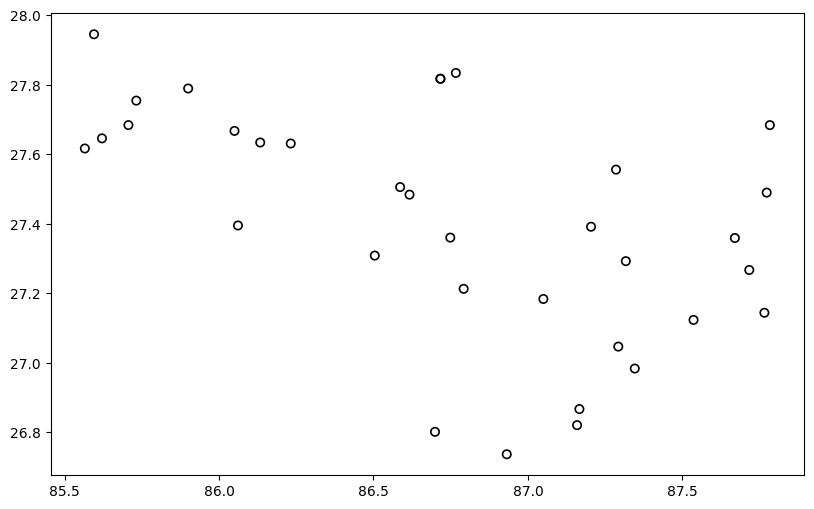

In [8]:






# Step 5: Plot Spatial Distribution of Tmax within the Koshi Basin boundary
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the basin boundary
basin_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1.2)

# Plot Tmax Kriging result
c_tmax = ax.contourf(grid_lon, grid_lat, z_tmax, cmap='coolwarm', levels=100)

# Add color bar
plt.colorbar(c_tmax, ax=ax, label="Tmax (°C)")
plt.title(f'Spatial Distribution of Tmax in {year_to_analyze} (Koshi Basin)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Step 6: Plot Spatial Distribution of Tmin within the Koshi Basin boundary
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the basin boundary
basin_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1.2)

# Plot Tmin Kriging result
c_tmin = ax.contourf(grid_lon, grid_lat, z_tmin, cmap='coolwarm', levels=100)

# Add color bar
plt.colorbar(c_tmin, ax=ax, label="Tmin (°C)")
plt.title(f'Spatial Distribution of Tmin in {year_to_analyze} (Koshi Basin)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [31]:
# Define a coarser grid resolution (e.g., 50x50)
grid_lon = np.linspace(min(filtered_longitudes), max(filtered_longitudes), 50)
grid_lat = np.linspace(min(filtered_latitudes), max(filtered_latitudes), 50)

# Create meshgrid
grid_lon_mesh, grid_lat_mesh = np.meshgrid(grid_lon, grid_lat)

# Apply Kriging for Tmax with the loop backend and n_closest_points option
OK_tmax = OrdinaryKriging(filtered_longitudes, filtered_latitudes, filtered_tmax_values,
                          variogram_model='spherical', verbose=False, enable_plotting=False)

# Use the 'loop' backend for kriging with n_closest_points
z_tmax, ss_tmax = OK_tmax.execute('grid', grid_lon, grid_lat, backend='loop', n_closest_points=10)

# Apply Kriging for Tmin similarly
OK_tmin = OrdinaryKriging(filtered_longitudes, filtered_latitudes, filtered_tmin_values,
                          variogram_model='spherical', verbose=False, enable_plotting=False)

# Use the 'loop' backend for Tmin kriging
z_tmin, ss_tmin = OK_tmin.execute('grid', grid_lon, grid_lat, backend='loop', n_closest_points=10)

# Step 5: Plot Tmax
fig, ax = plt.subplots(figsize=(10, 6))
basin_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1.2)
c_tmax = ax.contourf(grid_lon_mesh, grid_lat_mesh, z_tmax, cmap='coolwarm', levels=100)
plt.colorbar(c_tmax, ax=ax, label="Tmax (°C)")
plt.title(f'Spatial Distribution of Tmax in Koshi Basin')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Step 6: Plot Tmin similarly
fig, ax = plt.subplots(figsize=(10, 6))
basin_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1.2)
c_tmin = ax.contourf(grid_lon_mesh, grid_lat_mesh, z_tmin, cmap='coolwarm', levels=100)
plt.colorbar(c_tmin, ax=ax, label="Tmin (°C)")
plt.title(f'Spatial Distribution of Tmin in Koshi Basin')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


LinAlgError: Matrix is singular.